<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNによる文章生成
+ seq2seq
 + 時系列から時系列へと変換する、新しい構造のニューラルネットワーク
 + 二つのRNNを組み合わせることで、seq2seqが実装できる。

## 言語モデルを使った文章生成

### RNNによる文章生成の手順
+ 与えられた単語から、次に出現する単語の確率分布を出力
+ 確率的に単語を選択していく。
+ その作業を繰り返す。

### 文書生成の実装

In [1]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 378 (delta 0), reused 0 (delta 0), pack-reused 373
Receiving objects: 100% (378/378), 7.91 MiB | 3.66 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [2]:
cd deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [3]:
ls

ch01/  ch03/  ch05/  ch07/  common/   LICENSE.md
ch02/  ch04/  ch06/  ch08/  dataset/  README.md


In [0]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id] # 最初に与える単語のid

    x = start_id
    while len(word_ids) < sample_size: # sample_sizeはサンプリングする単語の数
      x = np.array(x).reshape(1, 1)
      # 各単語のスコアを出力
      score = self.predict(x)
      # softmax関数で正規化
      p = softmax(score.flatten())

      # 確率分布からのサンプリング
      sampled = np.random.choice(len(p), size=1, p=p)

      if (skip_ids is None) or (sampled not in skip_ids): # 不要語などを指定して除外する
        x = sampled
        word_ids.append(int(x))

    return word_ids


In [5]:
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
# 学習済みモデルでの実行
model.load_params('ch06/Rnnlm.pkl')

# start文字とskip文字の設定
# start_word = 'the meaning of life is'
start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]
# start_id = word_to_id[start_word]

skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

Done
--------------------------------------------------
the meaning of life is a professional move that is n't large.
 i think they 're at home by married like a station.
 if you do n't live for mr. boyd 's similar problem at mandatory fusion minister brands inc. 's american medical agency but said that inflation came a record at a layoffs of gm 's total account to a little as possible world emissions of pulp prices for a customer of high-grade equity companies remain selling at declining as well in the bay area taiwan now to be complex and payouts at the list of big operations.
 at a


### さらに良い文章へ

In [0]:
# from ch07.rnnlm_gen import BetterRnnlmGen

# corpus, word_to_id, id_to_word = ptb.load_data('train')
# vocab_size = len(word_to_id)
# corpus_size = len(corpus)

# model = BetterRnnlmGen()
# # 学習済みモデルでの実行
# model.load_params('ch06/BetterRnnlm.pkl')

# # start文字とskip文字の設定
# start_word = 'you'
# start_id = word_to_id[start_word]
# skip_words = ['N', '<unk>', '$']
# skip_ids = [word_to_id[w] for w in skip_words]

# # 文章生成
# word_ids = model.generate(start_id, skip_ids)
# txt = ' '.join([id_to_word[i] for i in word_ids])
# txt = txt.replace(' <eos>', '.\n')
# print(txt)

## seq2seq

### seq2seqの原理
+ seq2seqはEncoder-Decoderモデルとも呼ばれる。
 + エンコードは、情報をある規則に基づいて変換すること
 + デコードはエンコードされた情報をもとの情報に戻すこと
 + EncoderはRNNを利用して、時系列データをhという隠れ状態ベクトルに変換
  + LSTMの隠れ状態hは固定長のベクトルとなる。よってEncoderは任意の長さの文章を固定長のベクトルに変換するものと考えることができる。
 + Decoderは隠れ状態ベクトルhをLSTMレイヤで受け取り、固定長のベクトルから任意の長さのベクトルに変換している。

### 時系列データの変換用のトイ・プロブレム
+ 時系列データの変換問題として、足算をseq2seqで行わせる。
+ この問題では文を単語ではなく文字単位で分割することを考える。

### 可変長の時系列データ
+ 可変長の時系列データをミニバッチ学習するための最も単純な方法はパディングを使うこと。
 + パディングは本来のデータを無効なデータ（空白文字など）で埋めてデータの長さを均一に揃えるテクニックのことを指す。
 + パディング専用の処理をseq2seqに加える必要がある。
  + Decoderでパディングが入力されたときには損失の結果に計上しないようにする。
  + Encoderでパディングが入力されたときには前時刻の入力をそのまま出力するようにする。パディングが存在しなかったかのように扱える。

### 足算データセット

In [7]:
import sys
sys.path.append('..')

from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
chart_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [8]:
print(x_train[0])
print(t_train[0])

[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]


In [9]:
print(' '.join([id_to_char[c] for c in x_train[0]]))
print(' '.join([id_to_char[c] for c in t_train[0]]))

7 1 + 1 1 8  
_ 1 8 9  


## seq2seqの実装

### Encoderクラス

In [0]:
class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    # 語彙数、文字ベクトルの次元数、LSTMレイヤの隠れ状態ベクトルの次元数
    V, D, H = vocab_size, wordvec_size, hidden_size

    # 重みパラメータの初期化
    rn = np.random.randn
    embed_W = (rn(V, D) / 100 ).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False) # 今回はTime LSTMレイヤは状態を維持しない

    # 重みパラメータと勾配をリストに集約
    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None

  def forward(self, xs):
    xs = self.embed.forward(xs) # time embeddingレイヤ
    hs = self.lstm.forward(xs) # time LSTMレイヤ
    self.hs = hs
    return hs[:, -1, :] # 最後の時刻の隠れ状態だけを取り出す

  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh # LSTMレイヤの最後の隠れ状態に対する勾配

    dout = self.lstm.backward(dhs) # time LSTMレイヤ
    dout = self.embed.backward(dout) # time embeddingレイヤ
    return dout

### Decoderクラス

In [0]:
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(D, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []

    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore) # softmax with lossレイヤから勾配を受け取って、Time Affineレイヤを通す
    dout = self.lstm.backward(dout) # Time LSTMレイヤを通す
    dout = self.embed.backward(dout) # Time Embeddingレイヤを通す
    dh = self.lstm.dh # 時間方向の勾配を取り出す
    return dh

  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id # 最初の単語のid
    self.lstm.set_state(h) # 最初の隠れ状態

    for _ in range(sample_size): # 生成する文字数
      x = np.array(sample_id).reshape((1, 1))
      out = self.embed.forward(x) # Time Embeddingレイヤ
      out = self.lstm.forward(out) # Time LSTMレイヤ
      score = self.affine.forward(out) # Tiem Affineレイヤ

      sample_id = np.argmax(score.flatten()) # affineレイヤが出力するスコアから最大値を持つ文字idを選ぶ
      sampled.append(int(sample_id))

    return sampled

### Seq2Seqクラス

In [0]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

In [0]:
class Seq2seq(BaseModel):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = encoder(V, D, H)
    self.decoder = Decoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

  def forward(self, xs, ts):
    decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

    h = self.encoder.forward(xs)
    score = self.decoder.forward(decoder_xs, h)
    loss = self.softmax.forward(score, decoder_ts)
    return loss

  def backward(self, dout=1):
    dout = self.softmax.backward(dout)
    dh = self.decoder.backward(dout)
    dout = self.encoder.backward(dh)
    return dout

  def generate(self, xs, start_id, sample_size):
    h = self.encoder.forward(xs)
    sampled = self.decoder.generate(h, start_id, sample_size)
    return sampled

### seq2seqの評価
+ 1.学習データからミニバッチを選ぶ
+ 2.ミニバッチから勾配を計算する
+ 3.勾配を使ってパラメータを更新する

In [14]:
ls

ch01/  ch03/  ch05/  ch07/  common/   LICENSE.md
ch02/  ch04/  ch06/  ch08/  dataset/  README.md


In [16]:
import sys
sys.path.append('...')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# モデル / オプティマイザ / トレーナーの作成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1,
              batch_size=batch_size, max_grad=max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

ストリーミング出力は最後の 5000 行に切り捨てられました。
T 864 
☒ 862 
---
val acc 0.020%
Q 143+93 
T 236 
☑ 236 
---
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.040%
val acc 0.060%
val acc 0.060%
val acc 0.060%
val acc 0.060%
val acc 0.060%
val acc 0.060%
val acc 0.080%
val acc 0.080%
val acc 0.080%
val acc 0.080%
val acc 0.100%
val acc 0.100%
val acc 0.100%
val acc 0.100%
val acc 0.100%
val acc 0.120%
val acc 0.120%
val acc 0.120%
val acc 0.120%
val acc 0.120%
val acc 0.120%
val acc 0.120%
val acc 0.140%
val acc 0.140%
val acc 0.140%
val acc 0.140%
val acc 0.140%
val acc 0.140%
val acc

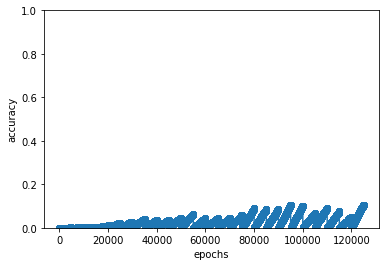

In [17]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

## seq2seqの改良

### 入力データの反転（Reverse）
+ 入力データの順序を反転させる
 + 多くの場合は学習の進みが速くなり、最終的な精度も良くなることが報告されている。
 + 仕組みとしては、反転することによって対応関係にある変換後の単語との距離が近くなるため、勾配が伝わりやすくなるとされている。

In [0]:
import sys
sys.path.append('...')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')

# データの反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
char_to_id, id_to_char = sequence.get_vocab()

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# モデル / オプティマイザ / トレーナーの作成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1,
              batch_size=batch_size, max_grad=max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

ストリーミング出力は最後の 5000 行に切り捨てられました。
Q  39+341
T 236 
☒ 238 
---
val acc 0.100%
val acc 0.100%
val acc 0.120%
val acc 0.120%
val acc 0.140%
val acc 0.140%
val acc 0.160%
val acc 0.160%
val acc 0.160%
val acc 0.160%
val acc 0.180%
val acc 0.200%
val acc 0.200%
val acc 0.200%
val acc 0.220%
val acc 0.220%
val acc 0.240%
val acc 0.240%
val acc 0.240%
val acc 0.240%
val acc 0.240%
val acc 0.240%
val acc 0.240%
val acc 0.260%
val acc 0.260%
val acc 0.260%
val acc 0.260%
val acc 0.280%
val acc 0.300%
val acc 0.300%
val acc 0.320%
val acc 0.320%
val acc 0.340%
val acc 0.360%
val acc 0.360%
val acc 0.360%
val acc 0.380%
val acc 0.400%
val acc 0.420%
val acc 0.440%
val acc 0.460%
val acc 0.480%
val acc 0.500%
val acc 0.500%
val acc 0.520%
val acc 0.540%
val acc 0.560%
val acc 0.580%
val acc 0.580%
val acc 0.600%
val acc 0.600%
val acc 0.600%
val acc 0.600%
val acc 0.600%
val acc 0.600%
val acc 0.620%
val acc 0.620%
val acc 0.620%
val acc 0.640%
val acc 0.640%
val acc 0.660%
val acc 0.660%
val acc 0.

In [0]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

### 覗き見（Peeky）
+ 重要な情報のつまったEncoderの出力hをDecoderの他のレイヤにも与える
 + 全ての時刻のAffineレイヤとLSTMレイヤにEncoderの出力を与える。
 + 大事な情報は一つのところに共有するのではなくいろいろなところで共有するべき。